# Project 1: SEIR
    Abraham Harris

In [1]:
import numpy as np
import networkx as nx
import plotting_utilities as pu
import matplotlib.pyplot as plt
from scipy.io import mmread

In [17]:
# Base parameters
mu_E = 1         # "exposed," incubation period mean--infected but not contagious
sigma_E = 1      # "exposed," incubation period s.d.
mu_I = 2.25      # "infectious," length of infection mean
sigma_I = 0.105  # "infectious", length of infection s.d.
p_1c = 0.12      # infectiousness parameter
beta = -0.00504  # infectiousness parameter
time_steps = 100
num_trials = 100

In [129]:
# Experimental parameters
mu_E = 1         # "exposed," incubation period mean--infected but not contagious
sigma_E = 1      # "exposed," incubation period s.d.
mu_I = 1.5       # "infectious," length of infection mean
sigma_I = 0.105  # "infectious", length of infection s.d.
p_1c = 0.05      # infectiousness parameter
beta = -0.00504  # infectiousness parameter
time_steps = 100
num_trials = 100

In [130]:
class Agent:
    def __init__(self, identifier, state="S"):
        """Each agent is identified by an integer and corresponds to that node in graph G."""
        # Sample from lognormal dist. to see how long exposed/infectious
        d_E = np.ceil(np.random.lognormal(mu_E, sigma_E)) # duration for exposed stage
        d_I = np.ceil(np.random.lognormal(mu_I, sigma_I)) # duration for infectious stage

        self.identifier = identifier
        self.countdown_to_infectious = d_E
        self.countdown_to_recovered = d_I
        self.days_spent_infectious = 0
        self.initial_state = state
        self.state = state
        

class Population:
    def __init__(self, G):
        """Accept a graph G. Set node states with 90% 'S', 5% 'E', and 5% 'I'."""
        # Set starting values
        self.G = G
        n = self.G.number_of_nodes()
        S_count = int(np.round(0.9*n))
        E_count = int(np.round(0.05*n))
        I_count = int(np.round(0.05*n))
        # Adjust for rounding issues
        while S_count + E_count + I_count < n:
            S_count += 1
        while S_count + E_count + I_count > n:
            S_count -= 1
        self.S = S_count
        self.E = E_count
        self.I = I_count
        self.R = 0

        # Make agents and match them to graph nodes
        self.agents = []
        counter = 0
        indices = np.arange(n) 
        self.index_to_agent = dict()
        np.random.shuffle(indices) # Prevent all nodes of low index having same state
        for _ in range(S_count):
            self.agents.append(Agent(int(indices[counter]), state="S"))
            self.G.nodes[indices[counter]]["state"] = "S"
            self.index_to_agent[indices[counter]] = self.agents[-1]
            counter += 1
        for _ in range(E_count):
            self.agents.append(Agent(int(indices[counter]), state="E"))
            self.G.nodes[indices[counter]]["state"] = "E"
            self.index_to_agent[indices[counter]] = self.agents[-1]
            counter += 1
        for _ in range(I_count):
            self.agents.append(Agent(int(indices[counter]), state="I"))
            self.G.nodes[indices[counter]]["state"] = "I"
            self.index_to_agent[indices[counter]] = self.agents[-1]
            counter += 1
        np.random.shuffle(self.agents)

        # Store changed agents when needed for updating graphics
        self.changed_agents = []

    def step_agents(self):
        """Update states of all agents."""
        self.changed_agents = []

        for agent in self.agents:
            if agent.state == "S":
                neighbors = list(self.G.neighbors(agent.identifier))
                for i in neighbors:
                    if self.G.nodes[i]["state"] == "I":
                        d = self.agents[i].days_spent_infectious
                        # Infectiousness of neighbor i
                        p_i_inf = (p_1c/(1 - p_1c))*np.exp(beta*(d**3 - 1)) / (1 + (p_1c/(1 - p_1c))*np.exp(beta*(d**3 - 1)))
                        r = np.random.uniform()
                        # Determine whether infected by neighbor i
                        if r < p_i_inf:
                            agent.state = "E"
                            self.G.nodes[agent.identifier]["state"] = "E"
                            self.changed_agents.append(agent.identifier)
                            self.S -= 1
                            self.E += 1
                            break
            elif agent.state == "E":
                agent.countdown_to_infectious -= 1
                if agent.countdown_to_infectious == 0:
                    agent.state = "I"
                    self.G.nodes[agent.identifier]["state"] = "I"
                    self.changed_agents.append(agent.identifier)
                    self.E -= 1
                    self.I += 1
            elif agent.state == "I":
                agent.countdown_to_recovered -= 1
                if agent.countdown_to_recovered == 0:
                    agent.state = "R"
                    self.G.nodes[agent.identifier]["state"] = "R"
                    self.changed_agents.append(agent.identifier)
                    self.I -= 1
                    self.R += 1


In [131]:
def run_experiment(G, num_trials, time_steps):
    """Run num_trials simulations of disease on graph G."""
    # Lists of lists that contain counts of each subpopulation at each time step
    S_runs = []
    E_runs = []
    I_runs = []
    R_runs = []

    for _ in range(num_trials):
        # Store subpopulation counts at each time step
        pop = Population(G)
        S_pop = [pop.S]
        E_pop = [pop.E]
        I_pop = [pop.I]
        R_pop = [pop.R]

        for _ in range(time_steps):
            # Simulation step
            pop.step_agents()

            # Update populations
            S_pop.append(pop.S)
            E_pop.append(pop.E)
            I_pop.append(pop.I)
            R_pop.append(pop.R)
            
        S_runs.append(S_pop)
        E_runs.append(E_pop)
        I_runs.append(I_pop)
        R_runs.append(R_pop)

    return S_runs, E_runs, I_runs, R_runs


def animate_simulation():
    """Show an animation of the contagion."""


def plot_simulation(S_runs, E_runs, I_runs, R_runs, title="SEIR Simulation"):
    """Make a time-series plot of the contagion given the population histories."""
    # Get values to plot
    S_low = np.quantile(S_runs, axis=0, q=0.25)
    S_av = np.median(S_runs, axis=0)
    S_high = np.quantile(S_runs, axis=0, q=0.75)
    E_low = np.quantile(E_runs, axis=0, q=0.25)
    E_av = np.median(E_runs, axis=0)
    E_high = np.quantile(E_runs, axis=0, q=0.75)
    I_low = np.quantile(I_runs, axis=0, q=0.25)
    I_av = np.median(I_runs, axis=0)
    I_high = np.quantile(I_runs, axis=0, q=0.75)
    R_low = np.quantile(R_runs, axis=0, q=0.25)
    R_av = np.median(R_runs, axis=0)
    R_high = np.quantile(R_runs, axis=0, q=0.75) 

    # Plot simulations
    plt.title(title)
    plt.plot(S_av, color="tab:blue", label="S")
    plt.plot(E_av, color="tab:orange", label="E")
    plt.plot(I_av, color="tab:green", label="I")
    plt.plot(R_av, color="tab:red", label="R")
    # Plot uncertainties (IQR)
    x = np.arange(len(S_av))
    plt.fill_between(x, S_low, S_high, color="tab:blue", alpha=0.3)
    plt.fill_between(x, E_low, E_high, color="tab:orange", alpha=0.3)
    plt.fill_between(x, I_low, I_high, color="tab:green", alpha=0.3)
    plt.fill_between(x, R_low, R_high, color="tab:red", alpha=0.3)
    plt.xlabel("Time Step")
    plt.ylabel("# of Individuals")
    plt.legend()
    plt.show()


def calculate_experiment_metrics(S_runs, I_runs):
    """
    Take in experiment data and calculate the following:
    - time to peak infection
    - peak infection
    - time to no new infections
    - number uninfected at the end
    """
    S_med = np.median(S_runs, axis=0)
    I_med = np.median(I_runs, axis=0)

    peak_infection = np.max(I_med)
    time_to_peak_infection = np.argmax(I_med)
    time_to_no_infections = np.where(I_med == 0)[0][0]
    num_uninfected = S_med[-1]

    return peak_infection, time_to_peak_infection, time_to_no_infections, num_uninfected

### Experiment 1: 
circulant graph with attachment to two neighbors per side (for testing simulation)

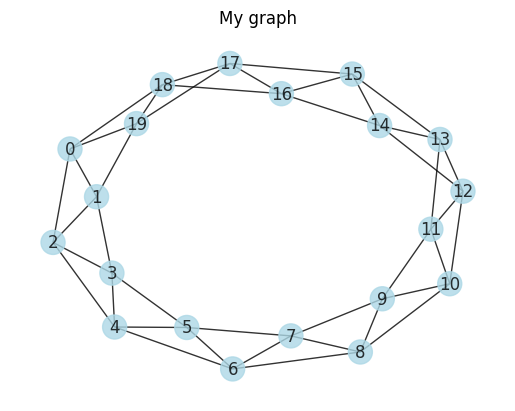

In [10]:
G1 = nx.circulant_graph(20, [1,2])
pu.show_graph(G1)

Peak infection: 6.0
Time to peak infection: 13
Time to no new infections: 55
Number of uninfected individuals at end: 0.0


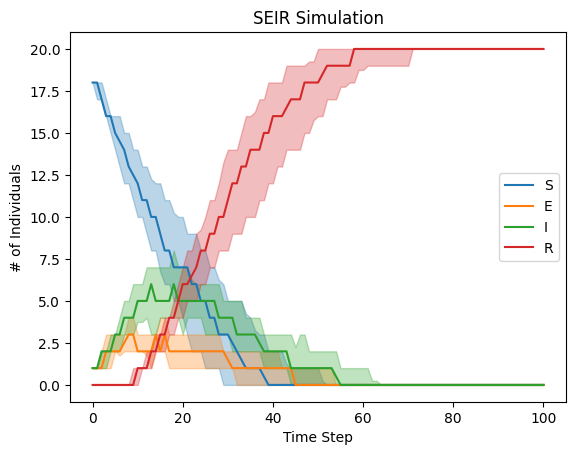

In [113]:
# Run simulation
S_runs, E_runs, I_runs, R_runs = run_experiment(G1, num_trials, time_steps)
peak_infection, time_to_peak_infection, time_to_no_infections, num_uninfected = calculate_experiment_metrics(S_runs, I_runs)
print(f"Peak infection: {peak_infection}")
print(f"Time to peak infection: {time_to_peak_infection}")
print(f"Time to no new infections: {time_to_no_infections}")
print(f"Number of uninfected individuals at end: {num_uninfected}")
# Generate visualizations
plot_simulation(S_runs, E_runs, I_runs, R_runs)

### Experiment 2:
circulant graph with attachment to four neighbors per side (for testing simulation)

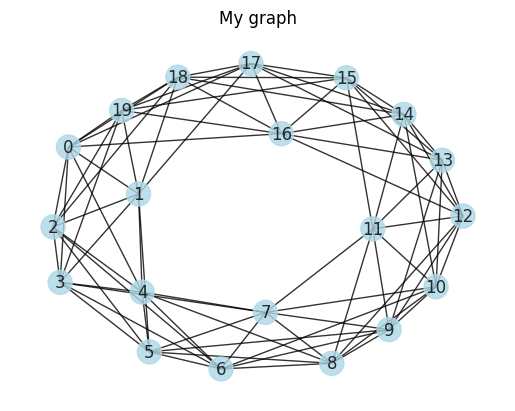

In [61]:
G2 = nx.circulant_graph(20, [1,2,3,4])
pu.show_graph(G2)

Peak infection: 6.0
Time to peak infection: 14
Time to no new infections: 54
Number of uninfected individuals at end: 0.0


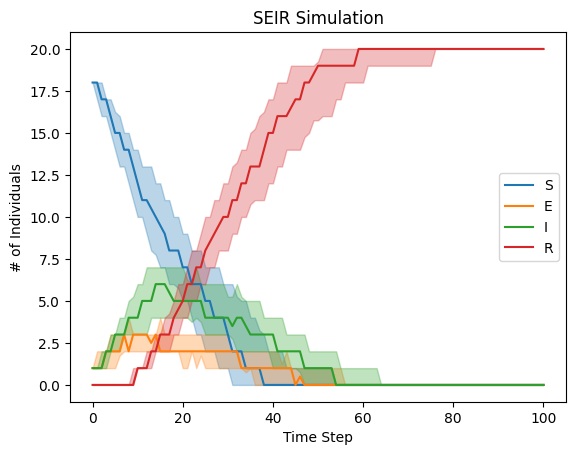

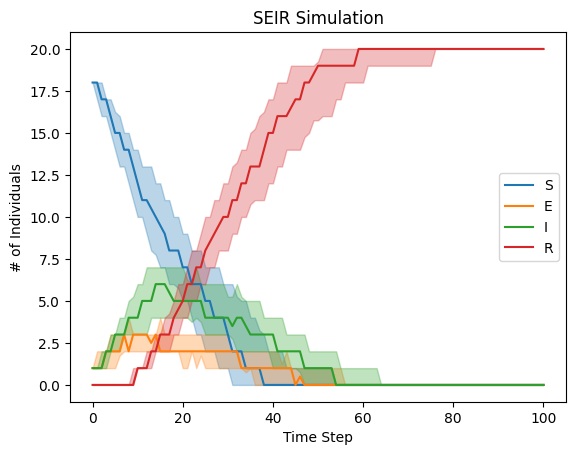

In [114]:
# Run simulation
S_runs, E_runs, I_runs, R_runs = run_experiment(G2, num_trials, time_steps)
# Run simulation
S_runs, E_runs, I_runs, R_runs = run_experiment(G1, num_trials, time_steps)
peak_infection, time_to_peak_infection, time_to_no_infections, num_uninfected = calculate_experiment_metrics(S_runs, I_runs)
print(f"Peak infection: {peak_infection}")
print(f"Time to peak infection: {time_to_peak_infection}")
print(f"Time to no new infections: {time_to_no_infections}")
print(f"Number of uninfected individuals at end: {num_uninfected}")
# Generate visualizations
plot_simulation(S_runs, E_runs, I_runs, R_runs)
# Generate visualizations
plot_simulation(S_runs, E_runs, I_runs, R_runs)

### Experiment 3:
complete graph with 100 vertices

In [66]:
G3 = nx.complete_graph(100)
# pu.show_graph(G3)

Peak infection: 58.0%
Time to peak infection: 7
Time to no new infections: 32
Number of uninfected individuals at end: 0.0


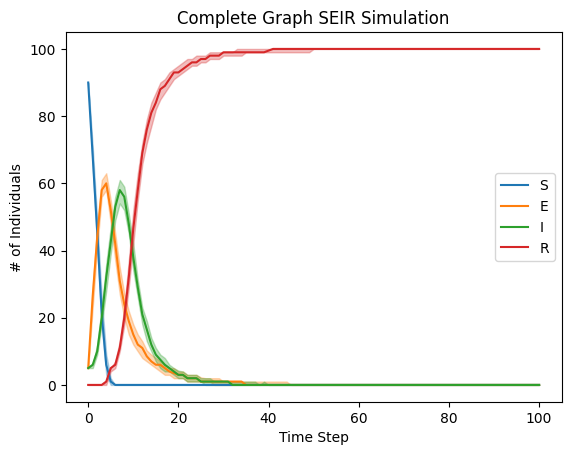

In [132]:
# Run simulation
S_runs, E_runs, I_runs, R_runs = run_experiment(G3, num_trials, time_steps)
peak_infection, time_to_peak_infection, time_to_no_infections, num_uninfected = calculate_experiment_metrics(S_runs, I_runs)
print(f"Peak infection: {peak_infection}%")
print(f"Time to peak infection: {time_to_peak_infection}")
print(f"Time to no new infections: {time_to_no_infections}")
print(f"Number of uninfected individuals at end: {num_uninfected}")
# Generate visualizations
plot_simulation(S_runs, E_runs, I_runs, R_runs, title="Complete Graph SEIR Simulation")

Max degree: 99
Average degree: 99.0
Diameter: 1
Radius: 1
Density: 1.0


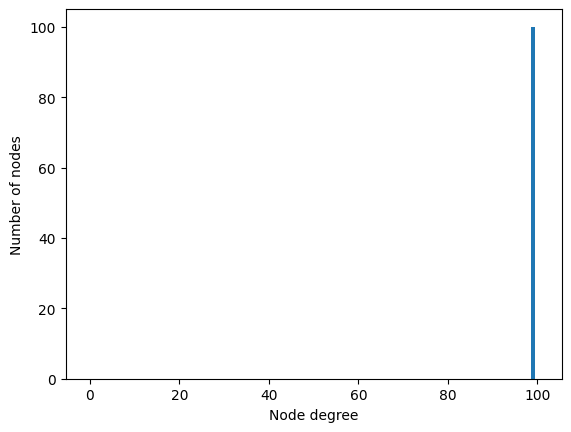

In [39]:
pu.show_degree_distribution(G3)
node_degrees = nx.degree(G3)
degrees = [n[1] for n in node_degrees]
print(f"Max degree: {max(degrees)}")
print(f"Average degree: {sum(degrees) / len(degrees)}")
print(f"Diameter: {nx.diameter(G3)}")
print(f"Radius: {nx.radius(G3)}")
print(f"Density: {nx.density(G3)}")

### Experiment 4:
10x10 lattice with 100 vertices

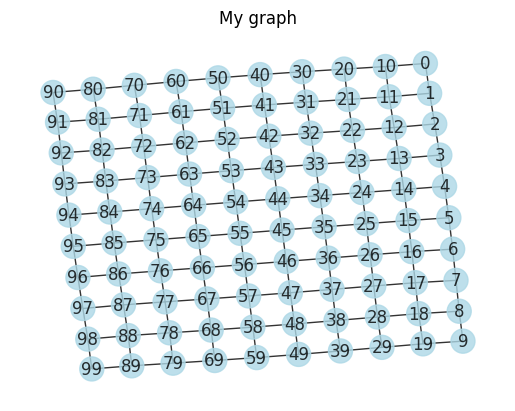

Max degree: 4
Average degree: 3.6
Diameter: 18
Radius: 10
Density: 0.03636363636363636


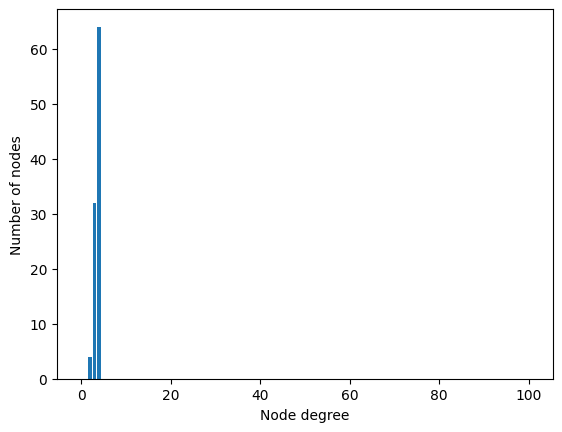

In [102]:
G4 = nx.grid_2d_graph(10, 10)
G4 = nx.convert_node_labels_to_integers(G4, first_label=0)
pu.show_graph(G4)
pu.show_degree_distribution(G4)
node_degrees = nx.degree(G4)
degrees = [n[1] for n in node_degrees]
print(f"Max degree: {max(degrees)}")
print(f"Average degree: {sum(degrees) / len(degrees)}")
print(f"Diameter: {nx.diameter(G4)}")
print(f"Radius: {nx.radius(G4)}")
print(f"Density: {nx.density(G4)}")

Peak infection: 8.0%
Time to peak infection: 3
Time to no new infections: 33
Number of uninfected individuals at end: 78.0


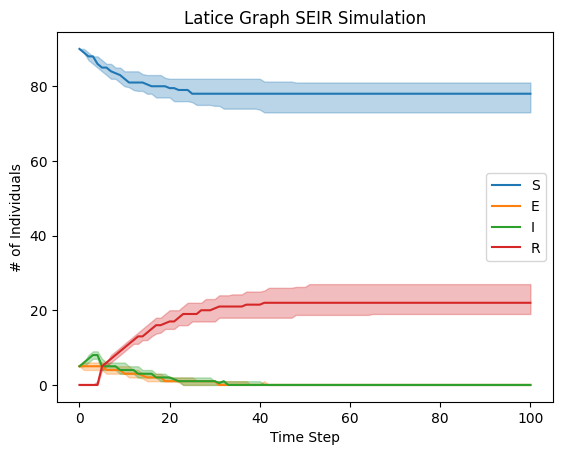

In [133]:
# Run simulation
S_runs, E_runs, I_runs, R_runs = run_experiment(G4, num_trials, time_steps)
peak_infection, time_to_peak_infection, time_to_no_infections, num_uninfected = calculate_experiment_metrics(S_runs, I_runs)
print(f"Peak infection: {peak_infection}%")
print(f"Time to peak infection: {time_to_peak_infection}")
print(f"Time to no new infections: {time_to_no_infections}")
print(f"Number of uninfected individuals at end: {num_uninfected}")
# Generate visualizations
plot_simulation(S_runs, E_runs, I_runs, R_runs, title="Latice Graph SEIR Simulation")

### Experiment 5:
scale-free network with 100 vertices

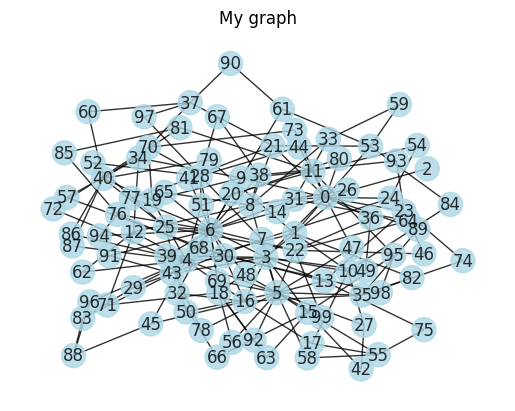

Max degree: 25
Average degree: 3.92
Diameter: 6
Radius: 4
Density: 0.039595959595959594


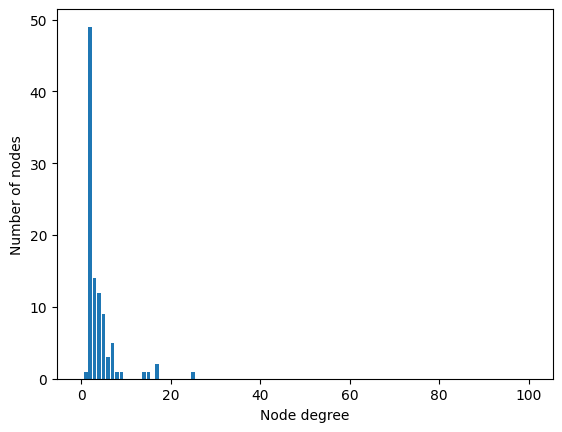

In [74]:
m = 2 # Note that we get to choose m (number of edges connected to each new node)
G5 = nx.barabasi_albert_graph(100, m)
pu.show_graph(G5)
pu.show_degree_distribution(G5)
node_degrees = nx.degree(G5)
degrees = [n[1] for n in node_degrees]
print(f"Max degree: {max(degrees)}")
print(f"Average degree: {sum(degrees) / len(degrees)}")
print(f"Diameter: {nx.diameter(G5)}")
print(f"Radius: {nx.radius(G5)}")
print(f"Density: {nx.density(G5)}")

Peak infection: 9.0
Time to peak infection: 4
Time to no new infections: 39
Number of uninfected individuals at end: 61.5


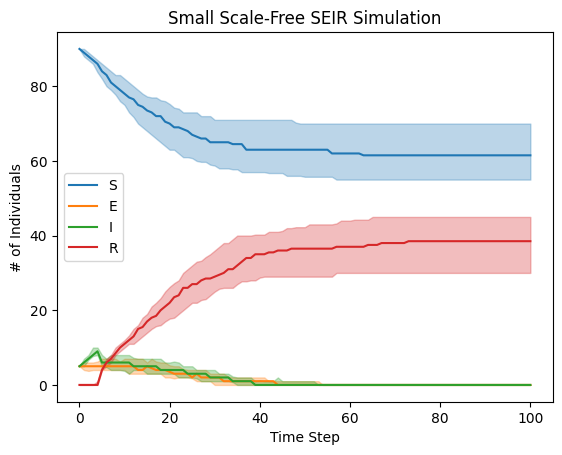

In [ ]:
# Run simulation
S_runs, E_runs, I_runs, R_runs = run_experiment(G5, num_trials, time_steps)
peak_infection, time_to_peak_infection, time_to_no_infections, num_uninfected = calculate_experiment_metrics(S_runs, I_runs)
print(f"Peak infection: {peak_infection}%")
print(f"Time to peak infection: {time_to_peak_infection}")
print(f"Time to no new infections: {time_to_no_infections}")
print(f"Number of uninfected individuals at end: {num_uninfected}")
# Generate visualizations
plot_simulation(S_runs, E_runs, I_runs, R_runs, title="Small Scale-Free SEIR Simulation")

### Experiment 6:
scale-free network with 410 vertices

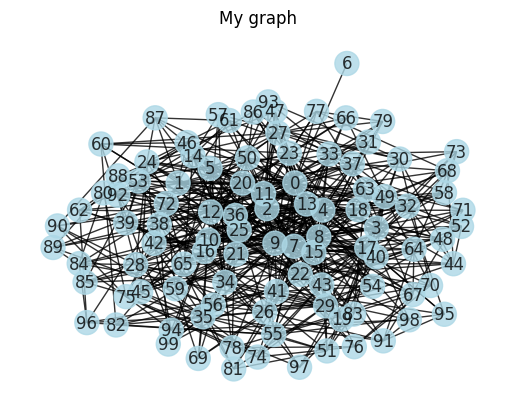

Max degree: 39
Average degree: 11.28
Diameter: 3
Radius: 2
Density: 0.11393939393939394


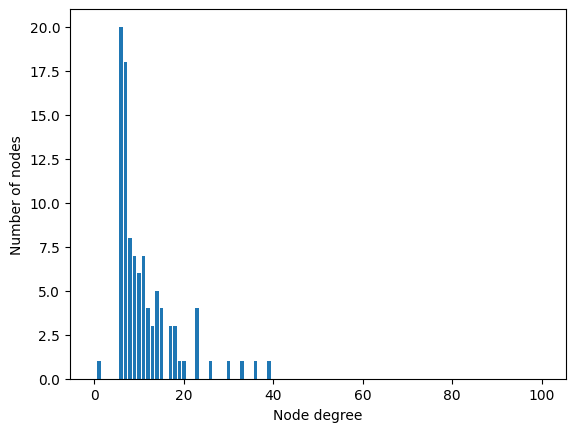

In [121]:
m = 6 # Note that we get to choose m (number of edges connected to each new node)
G6 = nx.barabasi_albert_graph(100, m)
pu.show_graph(G6)
pu.show_degree_distribution(G6)
node_degrees = nx.degree(G6)
degrees = [n[1] for n in node_degrees]
print(f"Max degree: {max(degrees)}")
print(f"Average degree: {sum(degrees) / len(degrees)}")
print(f"Diameter: {nx.diameter(G6)}")
print(f"Radius: {nx.radius(G6)}")
print(f"Density: {nx.density(G6)}")

Peak infection: 5.121951219512195%
Time to peak infection: 12
Time to no new infections: 46
Number of uninfected individuals at end: 12.0


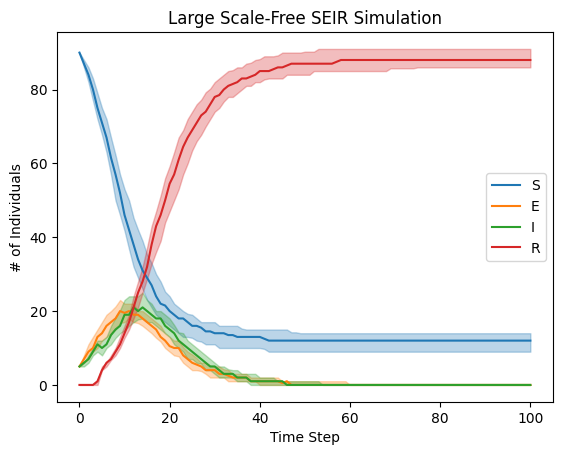

In [135]:
# Run simulation
S_runs, E_runs, I_runs, R_runs = run_experiment(G6, num_trials, time_steps)
peak_infection, time_to_peak_infection, time_to_no_infections, num_uninfected = calculate_experiment_metrics(S_runs, I_runs)
print(f"Peak infection: {peak_infection/410*100}%")
print(f"Time to peak infection: {time_to_peak_infection}")
print(f"Time to no new infections: {time_to_no_infections}")
print(f"Number of uninfected individuals at end: {num_uninfected}")
# Generate visualizations
plot_simulation(S_runs, E_runs, I_runs, R_runs, title="Large Scale-Free SEIR Simulation")

### Experiment 7:
infect-dublin network (410 vertices)

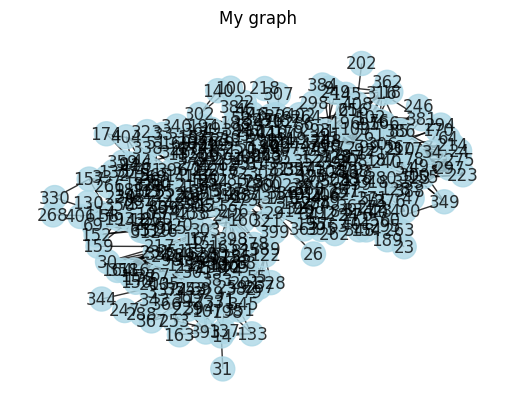

Max degree: 50
Average degree: 13.487804878048781
Diameter: 9
Radius: 5
Density: 0.032977518039239075


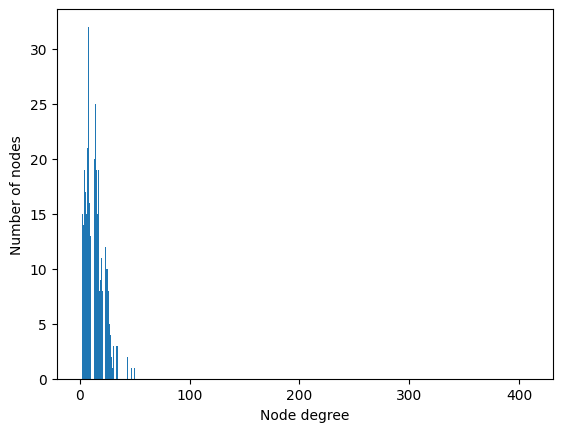

In [ ]:
def _read_graph_from_file(filename):
    fo = open(filename, 'r')
    line = fo.readline() # Read file header
    line = fo.readline() # Number of vertices and edges
    if not line:
        print('error-- illegal format for input')
        return
    v = line.split(" ")
    numVertices = int(v[0])
    G = nx.Graph()
    G.add_nodes_from(range(1,numVertices+1))
    while True:
        line = fo.readline()
        if not line:
            break
        #print("Line{}: {}".format(count,line.strip()))
        v = line.split(" ")
        v1 = int(v[0])
        v2 = int(v[1])
        G.add_edge(v1,v2)
        G.add_edge(v2,v1)
    fo.close()
    return G

file = "../data/ia-infect-dublin/ia-infect-dublin.mtx"
G7 = _read_graph_from_file(file)
mapping = {i: i - 1 for i in range(1, G7.number_of_nodes() + 1)} # Shift node numbers to be 0-indexed
G7 = nx.relabel_nodes(G7, mapping)
pu.show_graph(G7)
pu.show_degree_distribution(G7)
node_degrees = nx.degree(G7)
degrees = [n[1] for n in node_degrees]
print(f"Max degree: {max(degrees)}")
print(f"Average degree: {sum(degrees) / len(degrees)}")
print(f"Diameter: {nx.diameter(G7)}")
print(f"Radius: {nx.radius(G7)}")
print(f"Density: {nx.density(G7)}")

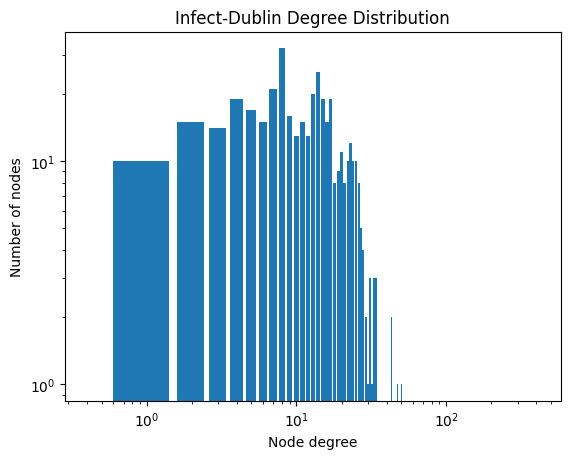

In [123]:
degree_count = pu.get_degree_count_dictionary(G7)
_, ax = plt.subplots()
ax.set_title("Infect-Dublin Degree Distribution")
ax.set_xlabel("Node degree")
ax.set_ylabel("Number of nodes")
ax.set_xscale("log")
ax.set_yscale("log")
degree_dict: dict[int, int] = {
    k: degree_count[k] if k in degree_count.keys() else 0
    for k in range(0, len(G7.nodes()) + 1)
}
plt.bar(
    [float(key) for key in degree_dict.keys()],
    [float(value) for value in degree_dict.values()],
)
plt.show()

Peak infection: 21.341463414634145%
Time to peak infection: 13
Time to no new infections: 61
Number of uninfected individuals at end: 58.0


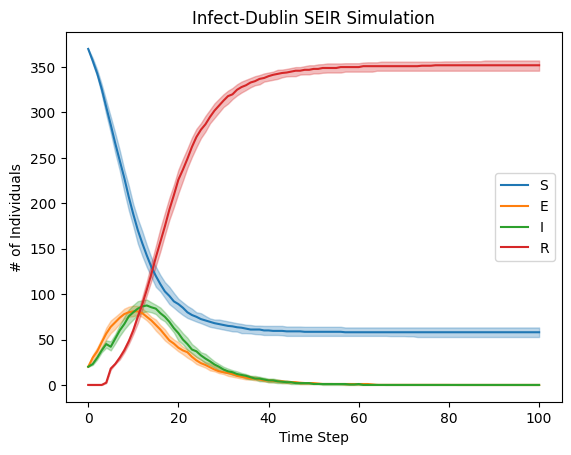

In [136]:
# Run simulation
S_runs, E_runs, I_runs, R_runs = run_experiment(G7, num_trials, time_steps)
peak_infection, time_to_peak_infection, time_to_no_infections, num_uninfected = calculate_experiment_metrics(S_runs, I_runs)
print(f"Peak infection: {peak_infection/410*100}%")
print(f"Time to peak infection: {time_to_peak_infection}")
print(f"Time to no new infections: {time_to_no_infections}")
print(f"Number of uninfected individuals at end: {num_uninfected}")
# Generate visualizations
plot_simulation(S_runs, E_runs, I_runs, R_runs, title="Infect-Dublin SEIR Simulation")

In [139]:
12/410*100

2.9268292682926833

In [95]:
print(list(G7.nodes)[-1])
print(len(G7.nodes))

409
410
